In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5,),(0.5,),)])

trainset = datasets.FashionMNIST("", download=True, train=True, transform=transform)
testset = datasets.FashionMNIST("", download=True, train=False, transform=transform)

trainLoader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)
testLoader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=True)



In [3]:
class_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [4]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return F.softmax(x, dim=1)
    
net = Net()
print(net)

Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [5]:
optimiser = optim.Adam(net.parameters(), lr=0.001)

EPOCHS = 5

for epoch in range(EPOCHS):
    for data in trainLoader:
        X, y = data
        net.zero_grad()
        output = net(X.view(-1, 28*28))
        loss = F.nll_loss(output, y)
        loss.backward()
        optimiser.step()
    print(loss)

tensor(-0.8211, grad_fn=<NllLossBackward0>)
tensor(-0.7995, grad_fn=<NllLossBackward0>)
tensor(-1.0000, grad_fn=<NllLossBackward0>)
tensor(-0.6000, grad_fn=<NllLossBackward0>)
tensor(-0.9000, grad_fn=<NllLossBackward0>)


In [6]:
correct = 0
total = 0

with torch.no_grad():
    for data in testLoader:
        X, y = data
        output = net(X.view(-1, 28*28))
        for idx, i in enumerate(output):
            if torch.argmax(i) == y[idx]:
                correct += 1
            total += 1

print("Accuracy: ", round(correct/total, 3))
print(correct)
print(total)

Accuracy:  0.832
8324
10000


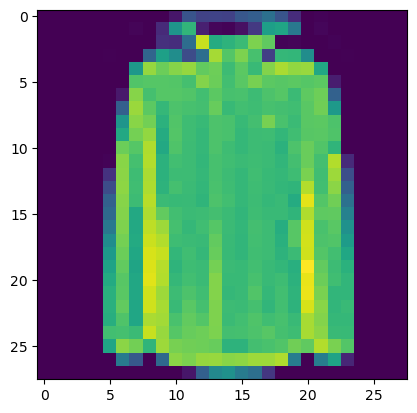

In [7]:
import matplotlib.pyplot as plt
plt.imshow(X[4].view(28,28))
plt.show()

In [8]:
labelIndex = 4
print(class_labels[torch.argmax(net(X[labelIndex].view(-1,784))[0])])
print(class_labels[y[labelIndex]])

Coat
Coat


In [9]:
net.eval()

Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [10]:
batch_size = 1
x = torch.randn(batch_size, 1, 784, requires_grad=True)
#x = torch.Tensor(X)
netOut = net(x)

torch.onnx.export(net,
                  x,
                  "fashionNet1.onnx",
                  export_params=True,
                  input_names=['input'],
                  do_constant_folding=True,
                  output_names=['output'],
                  dynamic_axes={'input' : {0 : 'batch_size'},
                                'output' : {0 : 'batch_size'}})

================ Diagnostic Run torch.onnx.export version 2.0.1 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [11]:
import onnx

onnx_model = onnx.load("fashionNet1.onnx")
onnx.checker.check_model(onnx_model)
print(onnx.helper.printable_graph(onnx_model.graph))

graph torch_jit (
  %input[FLOAT, batch_sizex1x784]
) initializers (
  %fc1.bias[FLOAT, 128]
  %fc2.bias[FLOAT, 10]
  %onnx::MatMul_13[FLOAT, 784x128]
  %onnx::MatMul_14[FLOAT, 128x10]
) {
  %/fc1/MatMul_output_0 = MatMul(%input, %onnx::MatMul_13)
  %/fc1/Add_output_0 = Add(%fc1.bias, %/fc1/MatMul_output_0)
  %/Relu_output_0 = Relu(%/fc1/Add_output_0)
  %/fc2/MatMul_output_0 = MatMul(%/Relu_output_0, %onnx::MatMul_14)
  %/fc2/Add_output_0 = Add(%fc2.bias, %/fc2/MatMul_output_0)
  %output = Softmax[axis = 1](%/fc2/Add_output_0)
  return %output
}


In [12]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("fashionNet1.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
#ort_outputs = ort_session.get_outputs()[0].name
ort_outs = ort_session.run(None, ort_inputs)

import numpy as np

np.testing.assert_allclose(to_numpy(netOut), ort_outs[0], rtol=1e-03, atol=1e-05)

print("Success")
print(ort_session)

Success


In [13]:
ort_outs[0]

array([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], dtype=float32)

In [14]:
netOut

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]],
       grad_fn=<SoftmaxBackward0>)

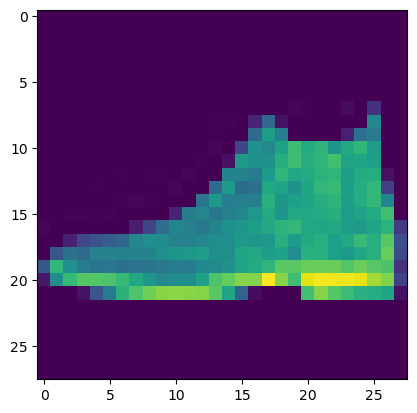

Ankle boot


In [15]:
X, y = testset[0]
plt.imshow(X.view(28,28))
plt.show()
print(class_labels[y])

In [16]:
print(class_labels[torch.argmax(net(X.view(1,784)))])

Ankle boot


In [17]:
to_numpy(net(X.view(1,784)))

array([[5.5007736e-34, 0.0000000e+00, 1.9008614e-40, 1.4019541e-38,
        0.0000000e+00, 5.4457325e-02, 0.0000000e+00, 1.6889545e-07,
        6.0064814e-29, 9.4554257e-01]], dtype=float32)

In [18]:
torch.argmax(torch.from_numpy(to_numpy(net(X.view(1,784)))))

tensor(9)

In [19]:
X = X.view(1,784).unsqueeze(0) #X.view(-1,784)
print({ort_session.get_inputs()[0].name: to_numpy(X)})

{'input': array([[[-1.        , -1.        , -1.        , -1.        ,
         -1.        , -1.        , -1.        , -1.        ,
         -1.        , -1.        , -1.        , -1.        ,
         -1.        , -1.        , -1.        , -1.        ,
         -1.        , -1.        , -1.        , -1.        ,
         -1.        , -1.        , -1.        , -1.        ,
         -1.        , -1.        , -1.        , -1.        ,
         -1.        , -1.        , -1.        , -1.        ,
         -1.        , -1.        , -1.        , -1.        ,
         -1.        , -1.        , -1.        , -1.        ,
         -1.        , -1.        , -1.        , -1.        ,
         -1.        , -1.        , -1.        , -1.        ,
         -1.        , -1.        , -1.        , -1.        ,
         -1.        , -1.        , -1.        , -1.        ,
         -1.        , -1.        , -1.        , -1.        ,
         -1.        , -1.        , -1.        , -1.        ,
         -1.  

In [20]:
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(X)}
#ort_outputs = ort_session.get_outputs()[0].name
out0 = ort_session.run(None, ort_inputs)

In [21]:
print(out0[0])
print(ort_session)

[[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]]


In [22]:
class_labels[torch.argmax(torch.from_numpy(out0[0]))]

'T-shirt/top'